In [87]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt



def fourier_matrix_2d_fast(func, Gx, Gy, a, resolution=100):
    Nx, Ny = len(Gx), len(Gy)
    x = np.linspace(0, a, resolution)
    y = np.linspace(0, a, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Calculer la fonction sur la grille
    f_values = func(X, Y)
    
    # Calculer la FFT 2D
    fft_values = np.fft.fft2(f_values)
    
    # Normaliser et réorganiser les fréquences
    fft_values = np.fft.fftshift(fft_values) / (resolution**2)
    
    # Extraire les coefficients de Fourier pour les harmoniques désirées
    Gx_indices = np.arange(Nx) - Nx//2
    Gy_indices = np.arange(Ny) - Ny//2
    result = fft_values[Nx//2 + Gx_indices[:, None], Ny//2 + Gy_indices]
    
    return result

def rcwa_2d_band_diagram(epsilon, a, num_harmonics, k_points):


    print('Start computing Fourier matrix....')
    N = 2*num_harmonics + 1
    G = 2*np.pi/a * np.arange(-num_harmonics, num_harmonics+1)
    Gx, Gy = np.meshgrid(G, G)
    E = fourier_matrix_2d_fast(epsilon, Gx.flatten(), Gy.flatten(), a=a)

    I = np.eye(N**2)
    Z = np.zeros((N**2, N**2))

    print('Start solving eigenvalue problem....')
    frequencies_tm = []
    frequencies_te = []
    for kx, ky in k_points:
        Kx = np.diag((kx + Gx.flatten()))
        Ky = np.diag((ky + Gy.flatten()))

        A_te = np.block([
            [Kx @ la.inv(E) @ Kx + Ky @ la.inv(E) @ Ky, Z],
            [Z, E]
        ])
        A_tm = np.block([
            [E, Z],
            [Z, Kx @ la.inv(E) @ Kx + Ky @ la.inv(E) @ Ky]
        ])

        eigenvalues_te, _ = la.eig(A_te)
        eigenvalues_tm, _ = la.eig(A_tm)
        
        # Traitement des valeurs propres TE
        processed_te = np.sqrt(np.abs(eigenvalues_te))

        # Traitement des valeurs propres TM
        processed_tm = np.sqrt(np.abs(eigenvalues_tm))

        # Stockage séparé des valeurs propres TE et TM
        frequencies_te.append(processed_te)
        frequencies_tm.append(processed_tm)

    return frequencies_te, frequencies_tm

# Exemple d'utilisation
def epsilon_2d(x, y):
    return 1 + 0.5 * (np.cos(2*np.pi*x/a)**2 + np.cos(2*np.pi*y/a)**2)



In [94]:
a = 1.  # période
num_harmonics = 3
k_path = np.array([
    [0, 0],      # Γ
    [np.pi/a, 0],  # X
    [np.pi/a, np.pi/a],  # M
    [0, 0]       # Γ
])

# Générer les points k le long du chemin
num_points = 100

k_points = np.concatenate([
    np.linspace(k_path[i], k_path[i+1], num_points) 
    for i in range(len(k_path)-1)
])


In [95]:
frequencies_te, frequencies_tm = rcwa_2d_band_diagram(epsilon_2d, a, num_harmonics, k_points)


Start computing Fourier matrix....
Start solving eigenvalue problem....


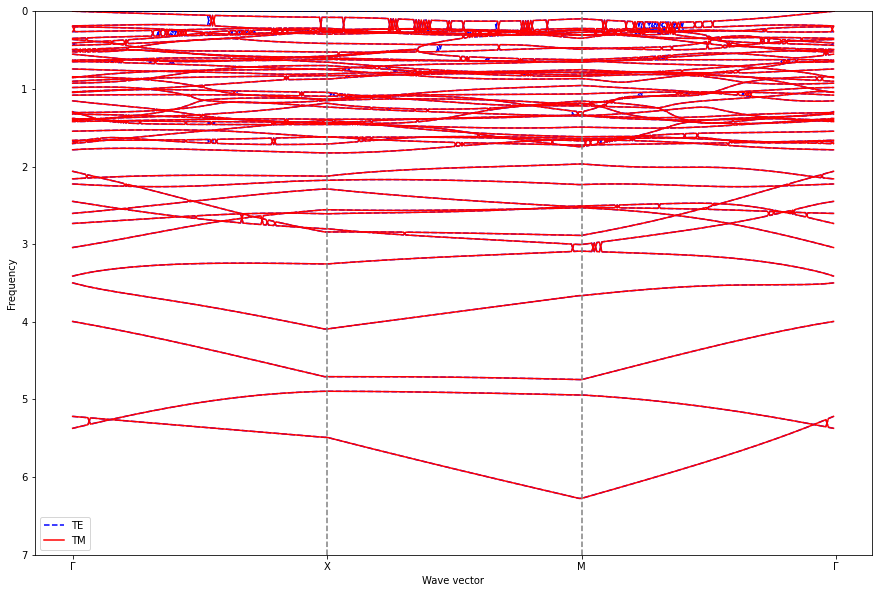

In [98]:
fig, ax = plt.subplots(figsize=(15, 10))
#plot the 1st 10 bands
for i in range(len(frequencies_te[0])):
    #plot the TE bands
    ax.plot(np.arange(len(k_points)), np.array(frequencies_te)[:,i]/1e10, color='blue', linestyle='--', label='TE')
    #plot the TM bands
    ax.plot(np.arange(len(k_points)), np.array(frequencies_tm)[:,i]/1e10, color='red', linestyle='-', label='TM')
ax.set_xticks([0, num_points, 2*num_points, 3*num_points])
#vertical lines at the k-points 
ax.axvline(x=num_points, color='gray', linestyle='--')
ax.axvline(x=2*num_points, color='gray', linestyle='--')
ax.set_xticklabels(['Γ', 'X', 'M', 'Γ'])
ax.set_xlabel('Wave vector')
ax.set_ylabel('Frequency')
ax.legend(['TE', 'TM'])
ax.set_ylim([7, 0])
plt.show()